In [1]:
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from yellowbrick.classifier.rocauc import roc_auc
from yellowbrick.contrib.wrapper import wrap,CLASSIFIER
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
import dice_ml
from yellowbrick.classifier.classification_report import classification_report

In [2]:
df = pd.read_csv("credit-g_csv.csv")
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,...,real estate,22,none,own,1,skilled,1,none,yes,bad
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,...,real estate,49,none,own,1,unskilled resident,2,none,yes,good
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,...,life insurance,45,none,for free,1,skilled,2,none,yes,good
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,...,no known property,53,none,for free,2,skilled,2,none,yes,bad


In [3]:
df.columns

Index(['checking_status', 'duration', 'credit_history', 'purpose',
       'credit_amount', 'savings_status', 'employment',
       'installment_commitment', 'personal_status', 'other_parties',
       'residence_since', 'property_magnitude', 'age', 'other_payment_plans',
       'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone',
       'foreign_worker', 'class'],
      dtype='object')

In [4]:
continious_cols = ['credit_amount', 'age']
df.loc[:,~df.columns.isin(continious_cols)] = df.loc[:,~df.columns.isin(continious_cols)].apply(
                                                                                    pd.Categorical
                                                                                    )
for each_col in df.loc[:,~df.columns.isin(continious_cols)].columns:
    df[each_col] = df[each_col].cat.codes

In [5]:
df.head().dtypes

checking_status            int8
duration                   int8
credit_history             int8
purpose                    int8
credit_amount             int64
savings_status             int8
employment                 int8
installment_commitment     int8
personal_status            int8
other_parties              int8
residence_since            int8
property_magnitude         int8
age                       int64
other_payment_plans        int8
housing                    int8
existing_credits           int8
job                        int8
num_dependents             int8
own_telephone              int8
foreign_worker             int8
class                      int8
dtype: object

In [6]:
df['existing_credits'].value_counts()

0    633
1    333
2     28
3      6
Name: existing_credits, dtype: int64

In [7]:
pd.crosstab(df["class"],df['personal_status']).apply(lambda r: r/r.sum(), axis=0)

personal_status,0,1,2,3
class,,,,
0,0.351613,0.4,0.271739,0.266423
1,0.648387,0.6,0.728261,0.733577


<AxesSubplot:ylabel='Frequency'>

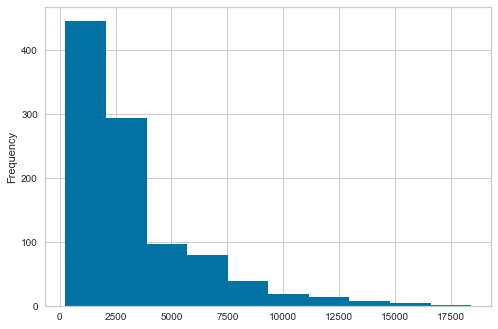

In [8]:
df["credit_amount"].plot(kind="hist")

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
                                                df.loc[:,~df.columns.isin(['class'])], 
                                                df['class'], 
                                    test_size=0.33, random_state=42, stratify=df['class'])

In [10]:
cols = df.columns.tolist()
cat_cols = set(cols).difference(set(continious_cols))
cat_cols = list(cat_cols)
cat_cols = [df.columns.get_loc(c) for c in cat_cols]


In [11]:
gbm = LGBMClassifier(is_unbalance=True)
gbm.fit(X_train,y_train,
       categorical_feature=cat_cols,
        eval_set=(X_test, y_test))

[1]	valid_0's binary_logloss: 0.597565
[2]	valid_0's binary_logloss: 0.589047
[3]	valid_0's binary_logloss: 0.580189
[4]	valid_0's binary_logloss: 0.576233
[5]	valid_0's binary_logloss: 0.570959
[6]	valid_0's binary_logloss: 0.569015
[7]	valid_0's binary_logloss: 0.570683
[8]	valid_0's binary_logloss: 0.570907
[9]	valid_0's binary_logloss: 0.573049
[10]	valid_0's binary_logloss: 0.573385
[11]	valid_0's binary_logloss: 0.574858
[12]	valid_0's binary_logloss: 0.574571
[13]	valid_0's binary_logloss: 0.572535
[14]	valid_0's binary_logloss: 0.572647
[15]	valid_0's binary_logloss: 0.57479
[16]	valid_0's binary_logloss: 0.575659
[17]	valid_0's binary_logloss: 0.577309
[18]	valid_0's binary_logloss: 0.57826
[19]	valid_0's binary_logloss: 0.580215
[20]	valid_0's binary_logloss: 0.581201
[21]	valid_0's binary_logloss: 0.582927
[22]	valid_0's binary_logloss: 0.582811
[23]	valid_0's binary_logloss: 0.582824
[24]	valid_0's binary_logloss: 0.586084
[25]	valid_0's binary_logloss: 0.583383
[26]	valid_

/Users/satyapattnaik/opt/anaconda3/envs/e2eml/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/satyapattnaik/opt/anaconda3/envs/e2eml/lib/python3.9/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20]
  warnings.warn('categorical_feature in Dataset is overridden.\n'
/Users/satyapattnaik/opt/anaconda3/envs/e2eml/lib/python3.9/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/satyapattnaik/opt/anaconda3/envs/e2eml/lib/python3.9/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


LGBMClassifier(is_unbalance=True)

In [12]:
prob_pos_clf = gbm.predict_proba(X_test)[:, 1]

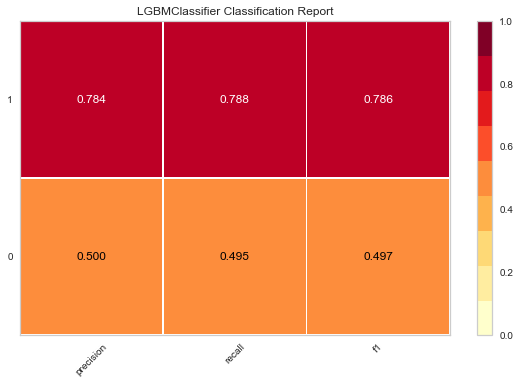

ClassificationReport(ax=<AxesSubplot:title={'center':'LGBMClassifier Classification Report'}>,
                     cmap=<matplotlib.colors.ListedColormap object at 0x7fa95bb5fc40>,
                     estimator=LGBMClassifier(is_unbalance=True),
                     is_fitted=True)

In [13]:

classification_report(gbm, X_train, y_train, X_test, y_test,is_fitted=True)

In [14]:
clf_isotonic = CalibratedClassifierCV(gbm, cv=2, method='isotonic')
clf_isotonic.fit(X_train, y_train,)
prob_pos_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]

In [15]:
clf_score = brier_score_loss(y_test, prob_pos_clf)
print("No calibration: %1.3f" % clf_score)

clf_isotonic_score = brier_score_loss(y_test, prob_pos_isotonic,
                                      )
print("With isotonic calibration: %1.3f" % clf_isotonic_score)

No calibration: 0.199
With isotonic calibration: 0.174


In [16]:
continious_cols

['credit_amount', 'age']

In [17]:


d = dice_ml.Data(dataframe=df,
                 continuous_features=continious_cols,
                 outcome_name='class')
# Pre-trained ML model
m = dice_ml.Model(model=clf_isotonic, backend='sklearn')
# DiCE explanation instance
exp = dice_ml.Dice(d,m)